# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

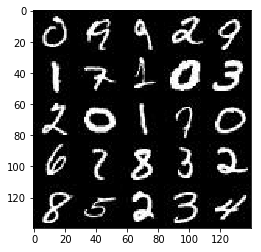

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

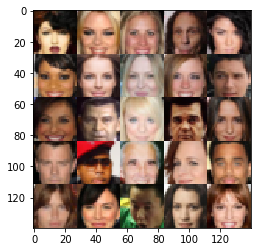

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.08
#    keep_prob = 0.8
        
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
 #       x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
#        x1 = tf.layers.dropout(x1, 0.1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
#        x2 = tf.layers.dropout(x2, 0.1)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
 #       x3 = tf.layers.dropout(x3, 1-keep_prob)
        # 4x4x256
  
        x4 = tf.layers.conv2d(x3, 512, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x3, training=True)
        x4 = tf.maximum(alpha * x3, x3)
#        x4 = tf.layers.dropout(x4, 0.1)
        # 2x2x512
        
        # Flatten it
        logits = tf.reshape(x4, (-1, 2*2*512))
        logits = tf.layers.dense(logits, 1)
#        logits = tf.layers.batch_normalization(logits, training=not reuse)
#        logits = tf.layers.dropout(logits, 1-keep_prob)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
VERBOSE = False

def log(s):
    global VERBOSE
    if VERBOSE: print(s)
    
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.08
#    keep_prob = 0.9

    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512,activation=None)
#        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
#        x1 = tf.layers.dropout(x1, keep_prob, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)  
        log('x1 {}'.format(x1.shape))
#       4 x 4 x 512

        x2= tf.layers.conv2d_transpose(x1, 256, 4 , strides=1, padding='VALID',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
#        x2 = tf.layers.dropout(x2, keep_prob, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        log('x2 {}'.format(x2.shape))
#       7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
#        x3 = tf.layers.dropout(x3, keep_prob, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        log('x3 {}'.format(x3.shape))
#        14 x 14 x 128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
#        x4 = tf.layers.dropout(x4, keep_prob, training = is_train)
        x4 = tf.maximum(alpha * x4, x4)
        log('x4 {}'.format(x4.shape))
#        28 x 28 x 64

        logits= tf.layers.conv2d_transpose(x3, out_channel_dim,3, strides=2, padding='SAME',kernel_initializer=tf.contrib.layers.xavier_initializer())
#        logits = tf.layers.batch_normalization(logits, training=is_train)
        out = tf.tanh(logits)
        log("out {}".format(out.shape))
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
       
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)      
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])   
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                batch_images = 2*batch_images
                print(".",end='')
                step += 1
                if step % 80 == 0:
                    print(" {}".format(step))
        
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:lr})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:lr})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:lr})
                
                if step % 80 == 0:
#                    print("{}-{}".format(batch_images.min(),batch_images.max()))
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
 
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                    if step % (80*5) == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

................................................................................ 80
Epoch 1/2... Discriminator Loss: 1.7114... Generator Loss: 0.3805
................................................................................ 160
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.5844
................................................................................ 240
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5910
................................................................................ 320
Epoch 1/2... Discriminator Loss: 2.0253... Generator Loss: 0.2455
................................................................................ 400
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.5226


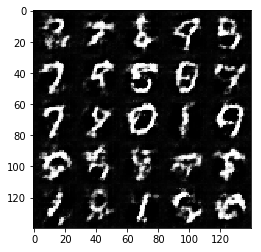

................................................................................ 480
Epoch 1/2... Discriminator Loss: 1.5508... Generator Loss: 0.5033
................................................................................ 560
Epoch 1/2... Discriminator Loss: 1.7371... Generator Loss: 0.3207
................................................................................ 640
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.5454
................................................................................ 720
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.4451
................................................................................ 800
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.8298


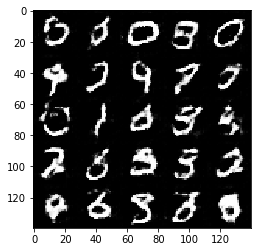

................................................................................ 880
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.3512
................................................................................ 960
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 1.1587
................................................................................ 1040
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.4077
................................................................................ 1120
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.7252
................................................................................ 1200
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.6850


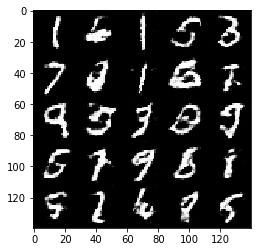

................................................................................ 1280
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.6039
................................................................................ 1360
Epoch 1/2... Discriminator Loss: 1.9948... Generator Loss: 0.2565
................................................................................ 1440
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.4373
................................................................................ 1520
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.8145
................................................................................ 1600
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.4222


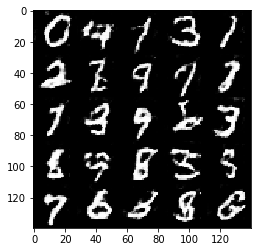

................................................................................ 1680
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.5049
................................................................................ 1760
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.5519
................................................................................ 1840
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.5517
................................................................................ 1920
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.7285
................................................................................ 2000
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.5598


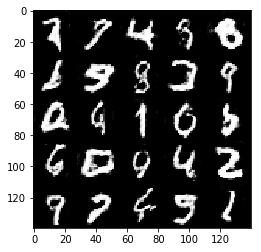

................................................................................ 2080
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 1.2453
................................................................................ 2160
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.9106
................................................................................ 2240
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.4151
................................................................................ 2320
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 0.7290
................................................................................ 2400
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 0.5779


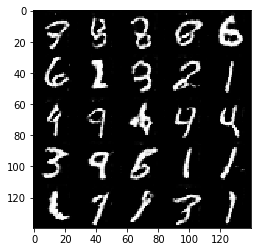

................................................................................ 2480
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.7033
................................................................................ 2560
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6985
................................................................................ 2640
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.8911
................................................................................ 2720
Epoch 1/2... Discriminator Loss: 1.6172... Generator Loss: 0.3875
................................................................................ 2800
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.5360


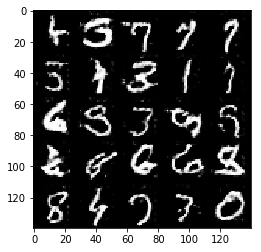

................................................................................ 2880
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.1684
................................................................................ 2960
Epoch 1/2... Discriminator Loss: 1.5864... Generator Loss: 0.4245
................................................................................ 3040
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.6502
................................................................................ 3120
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5775
................................................................................ 3200
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 1.1498


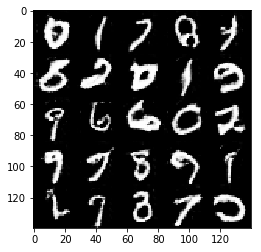

................................................................................ 3280
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 0.7473
................................................................................ 3360
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 0.9271
................................................................................ 3440
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.4881
................................................................................ 3520
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.4922
................................................................................ 3600
Epoch 1/2... Discriminator Loss: 1.9465... Generator Loss: 0.2720


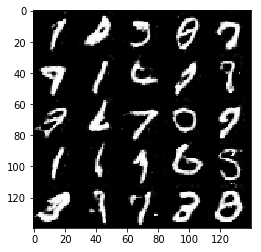

................................................................................ 3680
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.1815
...................................................................................................................................................... 80
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.1700
................................................................................ 160
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 2.2122
................................................................................ 240
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.6273
................................................................................ 320
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.5509
................................................................................ 400
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.8774


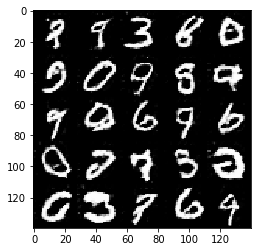

................................................................................ 480
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.5344
................................................................................ 560
Epoch 2/2... Discriminator Loss: 1.9836... Generator Loss: 0.2550
................................................................................ 640
Epoch 2/2... Discriminator Loss: 2.3873... Generator Loss: 0.2769
................................................................................ 720
Epoch 2/2... Discriminator Loss: 2.0930... Generator Loss: 0.2444
................................................................................ 800
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 1.0580


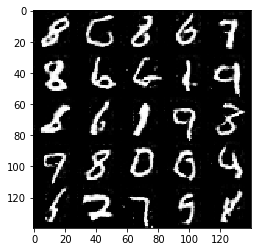

................................................................................ 880
Epoch 2/2... Discriminator Loss: 1.7759... Generator Loss: 0.3340
................................................................................ 960
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.9199
................................................................................ 1040
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 0.8749
................................................................................ 1120
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.5659
................................................................................ 1200
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.7854


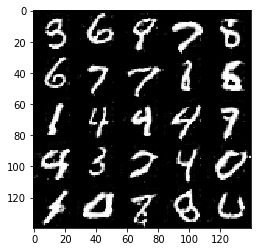

................................................................................ 1280
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 0.8609
................................................................................ 1360
Epoch 2/2... Discriminator Loss: 3.2997... Generator Loss: 0.0737
................................................................................ 1440
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6271
................................................................................ 1520
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.5462
................................................................................ 1600
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.6969


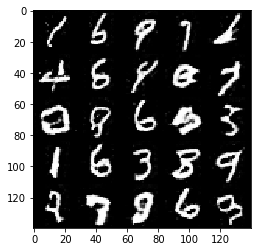

................................................................................ 1680
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.3326
................................................................................ 1760
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 0.3582
................................................................................ 1840
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.5413
................................................................................ 1920
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.5291
................................................................................ 2000
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.5869


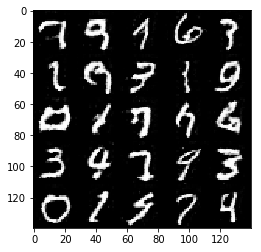

................................................................................ 2080
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.8244
................................................................................ 2160
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.9317
................................................................................ 2240
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.5162
................................................................................ 2320
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.7280
................................................................................ 2400
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.9302


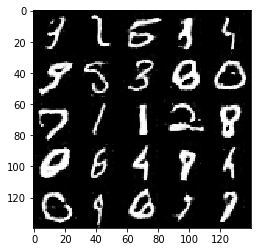

................................................................................ 2480
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.1361
................................................................................ 2560
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.5897
................................................................................ 2640
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.5746
................................................................................ 2720
Epoch 2/2... Discriminator Loss: 1.4808... Generator Loss: 0.4646
................................................................................ 2800
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.7372


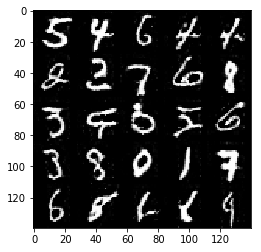

................................................................................ 2880
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.4953
................................................................................ 2960
Epoch 2/2... Discriminator Loss: 1.6883... Generator Loss: 0.3684
................................................................................ 3040
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4518
................................................................................ 3120
Epoch 2/2... Discriminator Loss: 1.7095... Generator Loss: 0.3906
................................................................................ 3200
Epoch 2/2... Discriminator Loss: 1.7813... Generator Loss: 0.4089


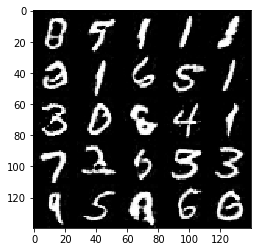

................................................................................ 3280
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 0.8267
................................................................................ 3360
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8851
................................................................................ 3440
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.5331
................................................................................ 3520
Epoch 2/2... Discriminator Loss: 1.6500... Generator Loss: 0.3848
................................................................................ 3600
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.3417


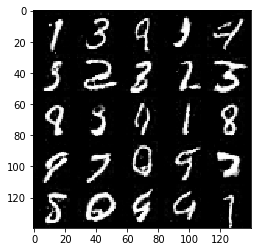

................................................................................ 3680
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.3463
......................................................................

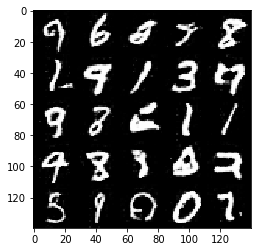

In [15]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

................................................................................ 80
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6705
................................................................................ 160
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6345
................................................................................ 240
Epoch 1/1... Discriminator Loss: 1.5946... Generator Loss: 0.6584
................................................................................ 320
Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.4658
................................................................................ 400
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.6806


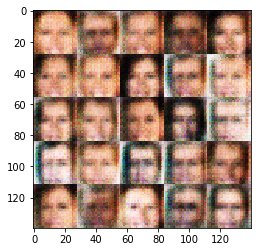

................................................................................ 480
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6850
................................................................................ 560
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6592
................................................................................ 640
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7069
................................................................................ 720
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6299
................................................................................ 800
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6327


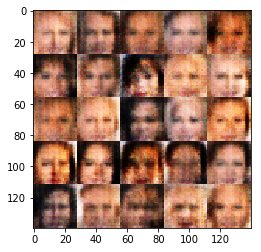

................................................................................ 880
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6444
................................................................................ 960
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7159
................................................................................ 1040
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7148
................................................................................ 1120
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7455
................................................................................ 1200
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7768


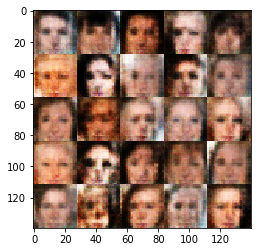

................................................................................ 1280
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7045
................................................................................ 1360
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7126
................................................................................ 1440
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6382
................................................................................ 1520
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7972
................................................................................ 1600
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7572


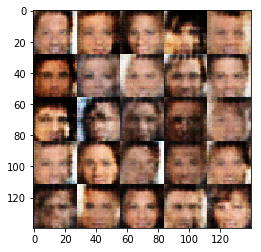

................................................................................ 1680
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7364
................................................................................ 1760
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7071
................................................................................ 1840
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7381
................................................................................ 1920
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7604
................................................................................ 2000
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7413


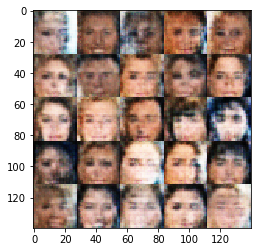

................................................................................ 2080
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7541
................................................................................ 2160
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6731
................................................................................ 2240
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7647
................................................................................ 2320
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7138
................................................................................ 2400
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7057


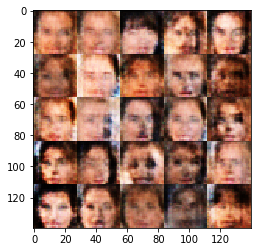

................................................................................ 2480
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7568
................................................................................ 2560
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7348
................................................................................ 2640
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6872
................................................................................ 2720
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7560
................................................................................ 2800
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6933


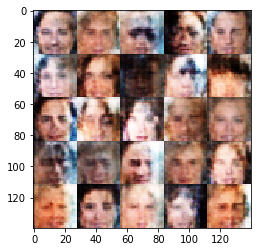

................................................................................ 2880
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7421
................................................................................ 2960
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7211
................................................................................ 3040
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7860
................................................................................ 3120
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7752
................................................................................ 3200
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7579


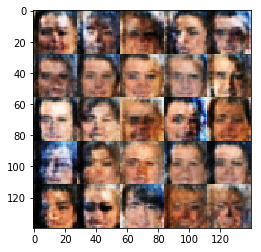

................................................................................ 3280
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7680
................................................................................ 3360
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7507
................................................................................ 3440
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7428
................................................................................ 3520
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7454
................................................................................ 3600
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7237


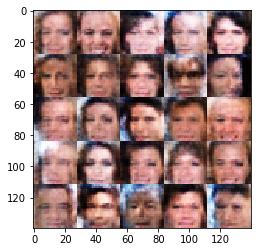

................................................................................ 3680
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7323
................................................................................ 3760
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7591
................................................................................ 3840
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7795
................................................................................ 3920
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7619
................................................................................ 4000
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7445


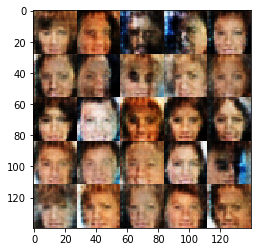

................................................................................ 4080
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6732
................................................................................ 4160
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7665
................................................................................ 4240
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8004
................................................................................ 4320
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8001
................................................................................ 4400
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7550


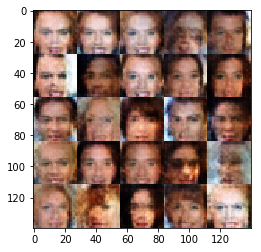

................................................................................ 4480
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7617
................................................................................ 4560
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7747
................................................................................ 4640
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7584
................................................................................ 4720
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7802
................................................................................ 4800
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7511


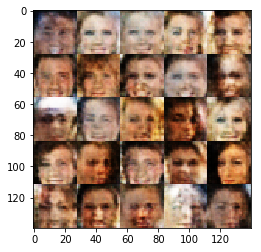

................................................................................ 4880
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7400
................................................................................ 4960
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7562
................................................................................ 5040
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7717
................................................................................ 5120
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7966
................................................................................ 5200
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7709


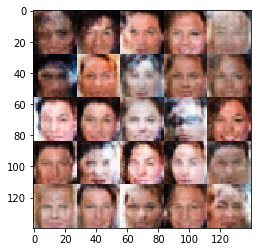

................................................................................ 5280
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7718
................................................................................ 5360
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7127
................................................................................ 5440
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7253
................................................................................ 5520
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7532
................................................................................ 5600
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7562


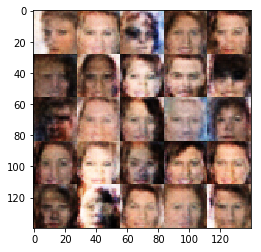

................................................................................ 5680
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7467
................................................................................ 5760
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7698
................................................................................ 5840
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7388
................................................................................ 5920
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7348
................................................................................ 6000
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7530


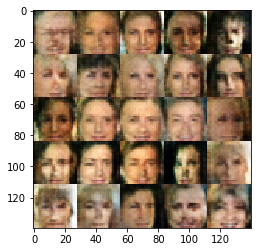

................................................................................ 6080
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8034
................................................................................ 6160
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7742
................................................................................ 6240
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7570
................................................................................ 6320
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7912
................................................................................ 6400
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7747


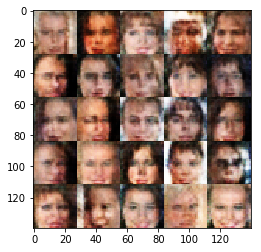

................................................................................ 6480
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7378
................................................................................ 6560
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7637
................................................................................ 6640
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7150
................................................................................ 6720
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7781
................................................................................ 6800
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7546


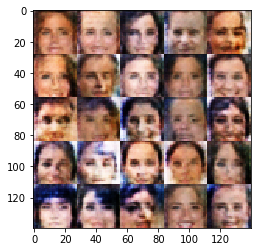

................................................................................ 6880
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7654
................................................................................ 6960
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7809
................................................................................ 7040
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7710
................................................................................ 7120
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7826
................................................................................ 7200
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7577


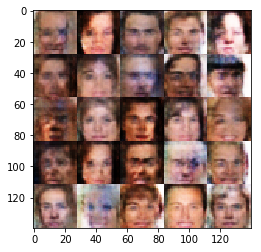

................................................................................ 7280
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7151
................................................................................ 7360
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7658
................................................................................ 7440
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7825
................................................................................ 7520
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7993
................................................................................ 7600
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7534


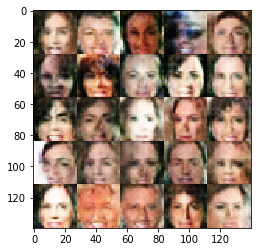

................................................................................ 7680
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7570
................................................................................ 7760
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7036
................................................................................ 7840
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8141
................................................................................ 7920
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7993
................................................................................ 8000
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7591


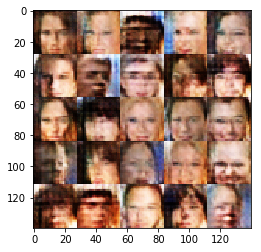

................................................................................ 8080
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7838
................................................................................ 8160
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7782
................................................................................ 8240
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7538
................................................................................ 8320
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7705
................................................................................ 8400
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7566


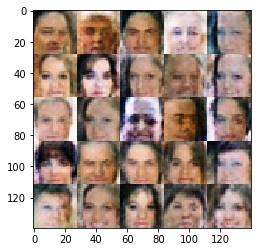

................................................................................ 8480
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7900
................................................................................ 8560
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7559
................................................................................ 8640
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7588
................................................................................ 8720
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7482
................................................................................ 8800
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7562


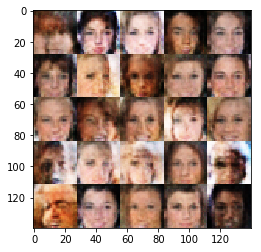

................................................................................ 8880
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7746
................................................................................ 8960
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7697
................................................................................ 9040
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7186
................................................................................ 9120
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7603
................................................................................ 9200
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7761


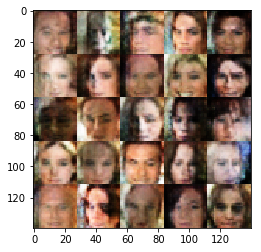

................................................................................ 9280
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7782
................................................................................ 9360
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7041
................................................................................ 9440
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7764
................................................................................ 9520
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7516
................................................................................ 9600
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7840


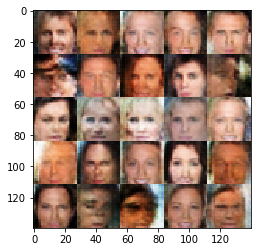

................................................................................ 9680
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7642
................................................................................ 9760
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7712
................................................................................ 9840
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7698
................................................................................ 9920
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8092
................................................................................ 10000
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7752


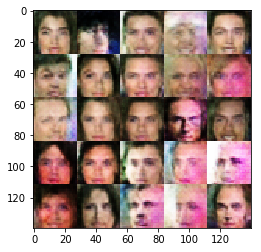

................................................................................ 10080
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7747
................................................................................ 10160
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7967
................................................................................ 10240
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7857
................................................................................ 10320
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7887
................................................................................ 10400
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8018


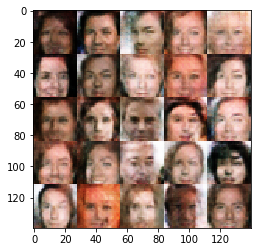

................................................................................ 10480
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7858
................................................................................ 10560
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7671
................................................................................ 10640
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7938
................................................................................ 10720
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7354
................................................................................ 10800
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7638


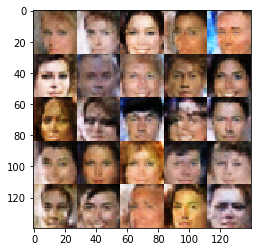

................................................................................ 10880
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7601
................................................................................ 10960
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7442
................................................................................ 11040
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7848
................................................................................ 11120
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7743
................................................................................ 11200
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7731


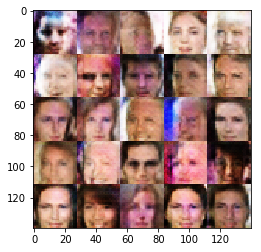

................................................................................ 11280
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7625
................................................................................ 11360
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7680
................................................................................ 11440
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7647
................................................................................ 11520
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6912
................................................................................ 11600
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7291


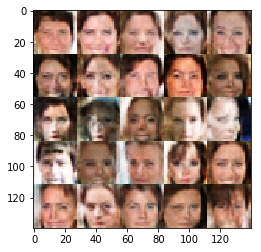

................................................................................ 11680
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7740
................................................................................ 11760
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7633
................................................................................ 11840
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7364
................................................................................ 11920
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7815
................................................................................ 12000
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7021


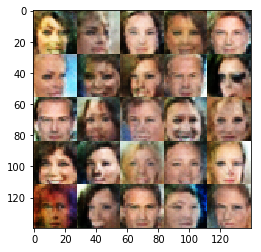

................................................................................ 12080
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7372
................................................................................ 12160
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7442
................................................................................ 12240
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7326
................................................................................ 12320
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7641
................................................................................ 12400
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7815


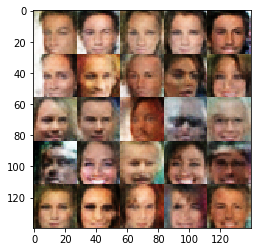

................................................................................ 12480
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7916
................................................................................ 12560
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7681
................................................................................ 12640
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7573
......................

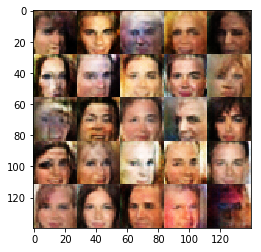

In [14]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.